<a href="https://colab.research.google.com/github/everson-alcantara/benchmark_tsinghua_analysis/blob/main/EEG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 15.3 MB/s eta 0:00:00


In [ ]:
!pip install -qU mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.8 MB/s eta 0:00:00


In [ ]:
import requests
import re
import os
import py7zr

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne

from bs4 import BeautifulSoup
from google.colab import drive
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, welch, freqz, spectrogram
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ia006/atividade1/data/'

# Tsinghua Benchmark Dataset
---
### This is a Public database developed by a research group at Tsinghua University, China, which is called Benchmark Dataset and is available at [Tsinghua BCI Lab](https://bci.med.tsinghua.edu.cn/download.html).

In [ ]:
# response = requests.get('https://bci.med.tsinghua.edu.cn/download.html')
# soup = BeautifulSoup(response.content, 'html.parser')

# links = list()
# with open('links.txt', 'w') as f:
#     for link in soup.find_all('a'):
#         if 'yijun' in str(link):
#             l = 'https://bci.med.tsinghua.edu.cn' + link.get('href')[1:] + '\n'
#             f.writelines(l)

In [ ]:
# !wget -i links.txt -P $DATA_PATH -nvc

# Dataset Description

This document describes the Steady-State Visually Evoked Potential Brain-Computer Interface (SSVEP-BCI) dataset collected from 35 healthy subjects.
The data focuses on responses to 40 visual characters flickering at different frequencies.

---

### Subject Information

* **Number of Subjects:** 35 (17 females, 18 males)
* **Age Range:** 17-34 years
* **Mean Age:** 22 years
* **Subject Grouping:**
    * **Experienced:** 8 subjects (S01-S08) with prior SSVEP-BCI experience.
    * **Naive:** 27 subjects (S09-S35) without prior SSVEP-BCI experience.
* **Subject Information File:** `Sub_info.txt` contains the following information for each subject:
    * `Subject Index` (e.g., S01)
    * `Gender`
    * `Age`
    * `Handedness`
    * `Group` (experienced or naive)

---

### Experimental Paradigm

Each subject participated in an experiment consisting of 6 blocks. Within each block, 40 trials were conducted, corresponding to each of the 40 target characters presented in a randomized order. Each trial followed this sequence:

1.  **Visual Cue:** A red square appeared for 0.5 seconds, indicating the target stimulus for that trial. Subjects were instructed to fix their gaze on the target as quickly as possible during this cue period.
2.  **Stimulus Flicker:** Following the cue, all 40 characters on the screen began to flicker simultaneously for 5 seconds. The flickering frequencies ranged from 8 Hz to 15.8 Hz, with an interval of 0.2 Hz between each character's frequency.
3.  **Fixation Aid:** A red triangle appeared below the flickering target during the entire 5-second stimulation period to help subjects maintain visual fixation.
4.  **Inter-Trial Interval:** A blank screen was displayed for 0.5 seconds after the stimulus offset, providing a short break before the next trial.
5.  **Total Trial Duration:** 6 seconds.

**Eye Blinks:** Subjects were instructed to avoid blinking during the 5-second stimulation period in each trial.

**Breaks:** Several minutes of rest were provided between consecutive blocks to minimize visual fatigue.

---

## EEG Data Acquisition

* **System:** Synamps2 system (Neuroscan, Inc.)
* **Sampling Rate:** 1000 Hz
* **Amplifier Passband:** 0.15 Hz to 200 Hz
* **Number of Electrodes:** 64
* **Electrode Placement:** Aligned according to the international 10-20 system, covering the whole scalp.
* **Ground Electrode:** Placed midway between Fz and FPz.
* **Reference Electrode:** Located at the vertex (Cz).
* **Electrode Impedance:** Kept below 10 KΩ.
* **Noise Reduction:** A notch filter at 50 Hz was applied during recording to remove power-line noise.
* **Event Triggers:** Computer-generated event triggers synchronized with the EEG data were recorded on a separate event channel.

---

## Data Preprocessing and Structure

1.  **Segmentation:** Continuous EEG data was segmented into 6-second epochs, spanning 500 ms before stimulus onset and 5.5 seconds after stimulus onset.
2.  **Downsampling:** The epochs were downsampled to 250 Hz. This resulted in 1500 time points per trial (6 seconds * 250 Hz).
3.  **Data Storage:** The preprocessed EEG data for each subject is stored in a separate MATLAB file (`.mat` format), named according to the subject index (e.g., `S01.mat`, ..., `S35.mat`).
4.  **MATLAB Data Structure:** Loading a subject's `.mat` file into MATLAB creates a 4-dimensional matrix named `data` with the following dimensions: `[64, 1500, 40, 6]`.
    * **Dimension 1 (64):** Electrode index, corresponding to the 64 EEG channels.
    * **Dimension 2 (1500):** Time points within each 6-second trial.
    * **Dimension 3 (40):** Target index, representing the 40 different flickering characters.
    * **Dimension 4 (6):** Block index, representing the six experimental blocks.

---

## Additional Files

* **Electrode Positions:** The file `64-channels.loc` contains the spatial locations of the 64 EEG electrodes.
* **Frequency and Phase Information:** The file `Freq_Phase.mat` stores the specific flickering frequency and phase values associated with each of the 40 target indices. There are six trials available for each SSVEP frequency across the experiment

This structured organization allows for efficient access and analysis of the recorded SSVEP-BCI data.

In [ ]:
montage = mne.channels.read_custom_montage(DATA_PATH + "64-channels.loc")

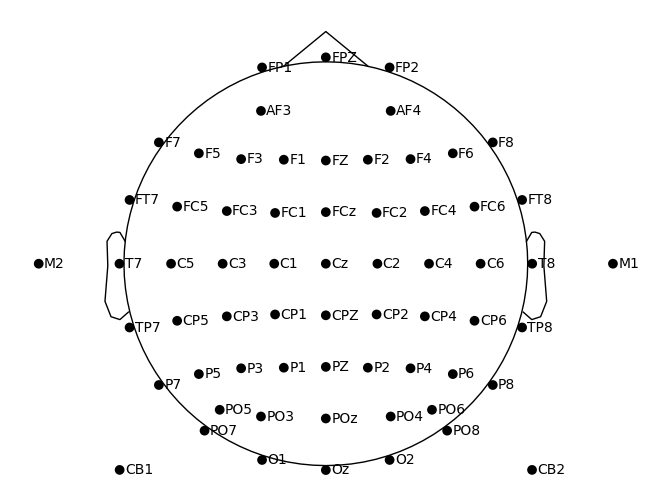

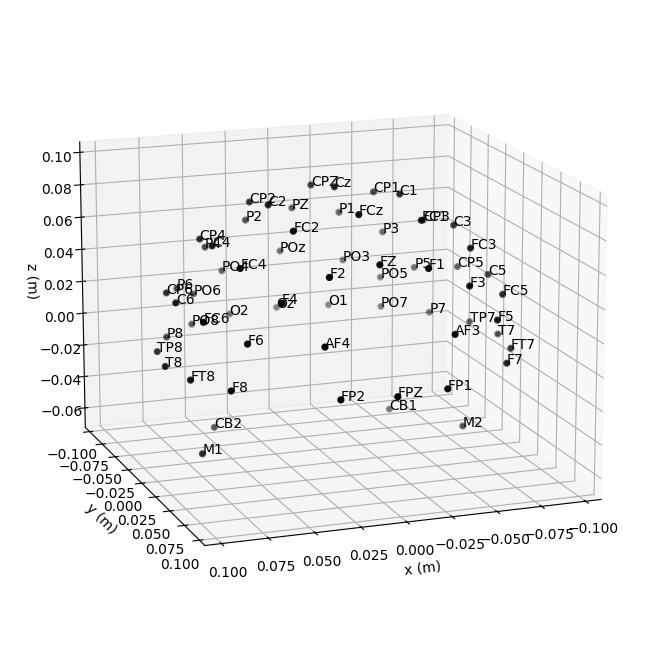

In [ ]:
montage.plot(kind='topomap',show_names=True)
fig = montage.plot(kind='3d', show=False)
fig.gca().view_init(azim=70, elev=15)

#### Trial Info

In [ ]:
trial_info = loadmat(DATA_PATH + 'Freq_Phase.mat')
trial_info = {k: v.flatten() for k, v in trial_info.items() if k in ['phases', 'freqs']}
trial_info = pd.DataFrame.from_dict(trial_info, orient='columns').reset_index()
trial_info['trial_no'] = trial_info['index'] + 1

In [ ]:
trial_info

,index,phases,freqs,trial_no
0,0,0.000000,8.0,1
1,1,1.570796,9.0,2
2,2,3.141593,10.0,3
3,3,4.712389,11.0,4
4,4,0.000000,12.0,5
5,5,1.570796,13.0,6
6,6,3.141593,14.0,7
7,7,4.712389,15.0,8
8,8,1.570796,8.2,9
9,9,3.141593,9.2,10


# Data Exploration
---
## Experienced User

In [ ]:
TRIAL = 3

In [ ]:
TRIAL_FREQ = trial_info.loc[trial_info['trial_no'].eq(TRIAL)]['freqs'].values[0]
TRIAL_FREQ

np.float64(10.0)

In [ ]:
with open(DATA_PATH + '64-channels.loc') as f:
    electrodes = f.readlines()

electrodes = [i.split() for i in electrodes if i][:-1]
electrodes = pd.DataFrame(electrodes, columns=['index', 'degree', 'radius', 'label'])

In [ ]:
ELEC_LABEL = ['Pz', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']

In [ ]:
ELEC_INDEX = electrodes[electrodes['label'].isin(ELEC_LABEL)]['index'].values.astype(int).tolist()
ELEC_INDEX

[54, 55, 56, 57, 58, 61, 62, 63]

In [ ]:
ELEC_LABEL = electrodes[electrodes["index"].isin(np.asarray(ELEC_INDEX).astype(str))]['label'].values.astype(str).tolist()
ELEC_LABEL

['PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']

In [ ]:
def load_user_data(user_id):

    sample_path = DATA_PATH + f'S{user_id}.mat'

    if not os.path.exists(sample_path):
        print(f'Extracted data from user {user_id} not found.')
        with py7zr.SevenZipFile(sample_path + '.7z', mode='r') as z:
            z.extractall(path=DATA_PATH)

    data = loadmat(sample_path)
    return data

In [ ]:
USER_ID = 3
data = load_user_data(USER_ID)

In [ ]:
volunteer_data = data.get("data")

In [ ]:
volunteer_data.shape

(64, 1500, 40, 6)

In [ ]:
# fs = 250
# cutoff = 3
# order = 5

# # Higpass filter
# b, a = butter(order, cutoff, fs=(fs/2), btype="high", analog=False)

# # Apply filter
# filtered_data = np.zeros_like(volunteer_data)

# # Apply the filter along the time axis (axis=1)
# for channel in tqdm(range(volunteer_data.shape[0])):
#   for trial in range(volunteer_data.shape[2]):
#     for block in range(volunteer_data.shape[3]):
#       signal_filtered = filtfilt(b, a, volunteer_data[channel, :, trial, block])
#       filtered_data[channel, :, trial, block] = signal_filtered

100%|██████████| 64/64 [00:04<00:00, 14.96it/s]


In [ ]:
# filtered_data.shape

(64, 1500, 40, 6)

In [ ]:
# N = filtered_data.shape[1]

## Time signal

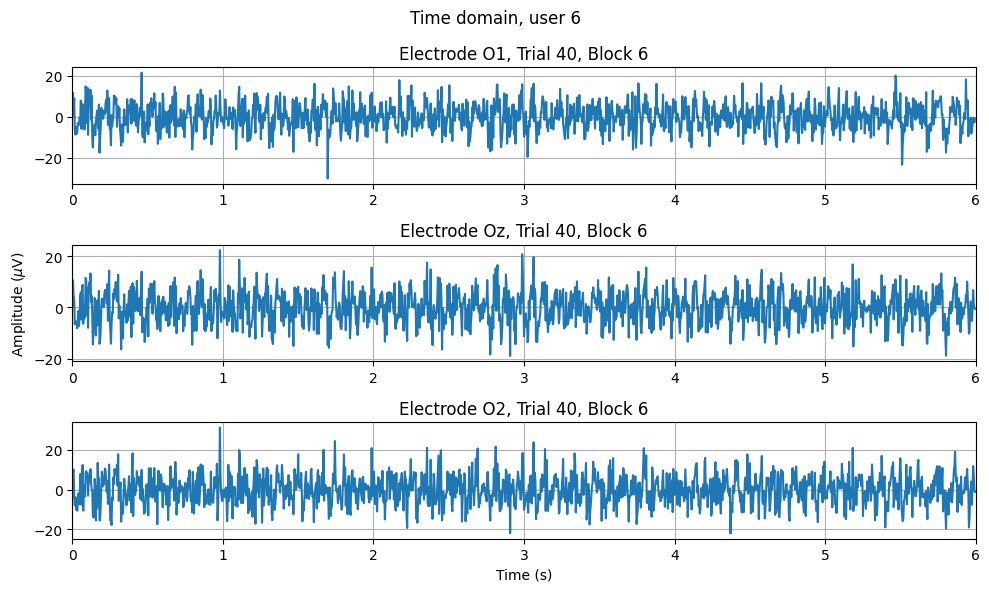

In [ ]:
t = np.arange(0, N / fs, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, e in enumerate(ELEC_INDEX):
    plot_eeg_time(ax=axs[i], x=t, y=filtered_data[e-1, :, TRIAL-1, BLOCK], title=f'Electrode {ELEC_LABEL[i]}, Trial {TRIAL}, Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Time domain, user {USER_ID}')
fig.tight_layout()
plt.show()

## DFT Magnitude

In [ ]:
def plot_eeg_freq(ax, x, y, title, add_xl, add_yl):

    ax.plot(x, y)
    ax.set_title(title)
    ax.set_xlim(0, 60)
    ax.grid(True)

    if add_xl:
        ax.set_xlabel('Frequency (Hz)')

    if add_yl:
        ax.set_ylabel('Magnitude')

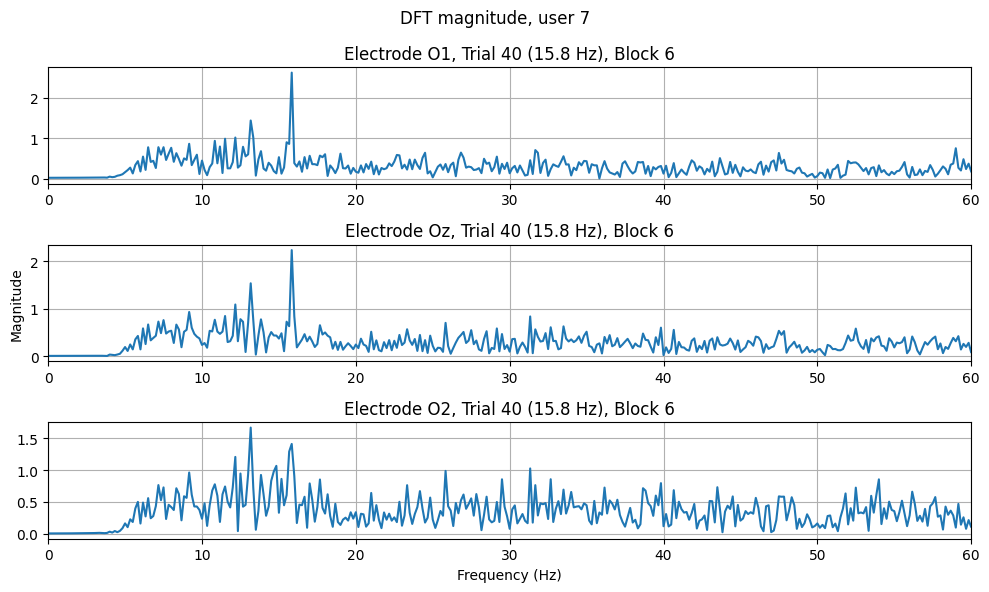

In [ ]:
freq = rfftfreq(N, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, e in enumerate(ELEC_INDEX):
    y = rfft(filtered_data[e-1, :, TRIAL-1, BLOCK])
    plot_eeg_freq(ax=axs[i], x=freq, y=2/N*np.abs(y), title=f'Electrode {ELEC_LABEL[i]}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'DFT magnitude, user {USER_ID+1}')
fig.tight_layout()
plt.show()

## PSD

In [ ]:
def plot_psd(ax, x, y, title, add_xl, add_yl, log=False):

    if log:
        ax.semilogy(x, y)
    else:
        ax.plot(x, y)

    ax.set_title(title)
    ax.set_xlim(5, 18)
    ax.grid(True)

    if add_xl:
        ax.set_xlabel('Frequency (Hz)')

    if add_yl:
        ax.set_ylabel('PSD')

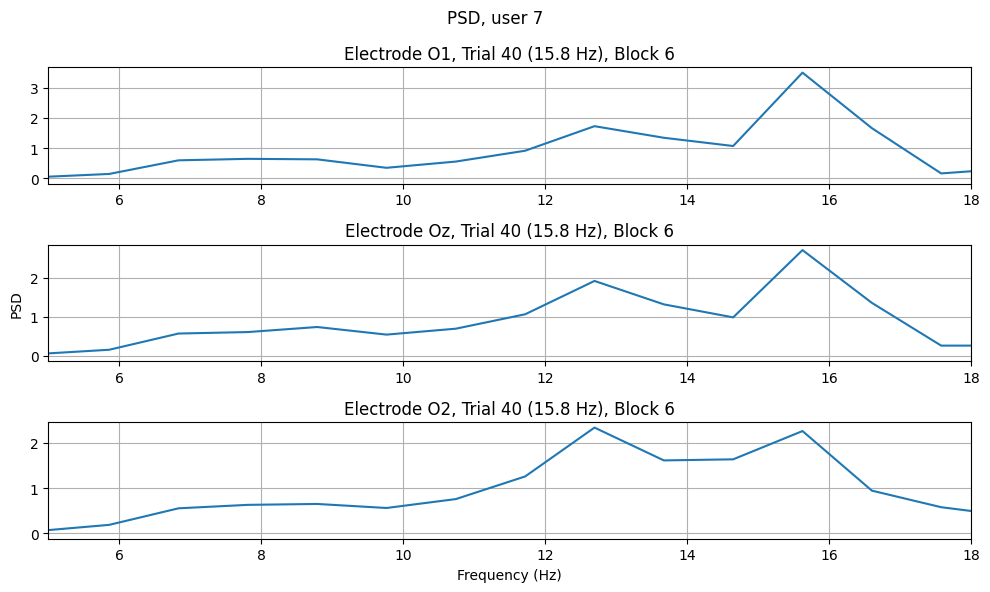

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, e in enumerate(ELEC_INDEX):
    f, psd = welch(filtered_data[e-1, :, TRIAL-1, BLOCK], fs, scaling="density")
    plot_psd(ax=axs[i], x=f, y=psd, title=f'Electrode {ELEC_LABEL[i]}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'PSD, user {USER_ID+1}')
fig.tight_layout()
plt.show()

## Spectogram

In [ ]:
def plot_spectrogram(ax, x, y, z, title, add_xl, add_yl):
    # Create the spectrogram
    im = ax.pcolormesh(x, y, z, shading='gouraud')

    # Add a colorbar
    fig = plt.gcf() # Get the current figure
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('(dB)') # Set colorbar label


    ax.set_title(title)
    ax.set_ylim(5, 18)
    if add_xl:
        ax.set_xlabel('Time (s)')

    if add_yl:
        ax.set_ylabel('Frequency (Hz)')

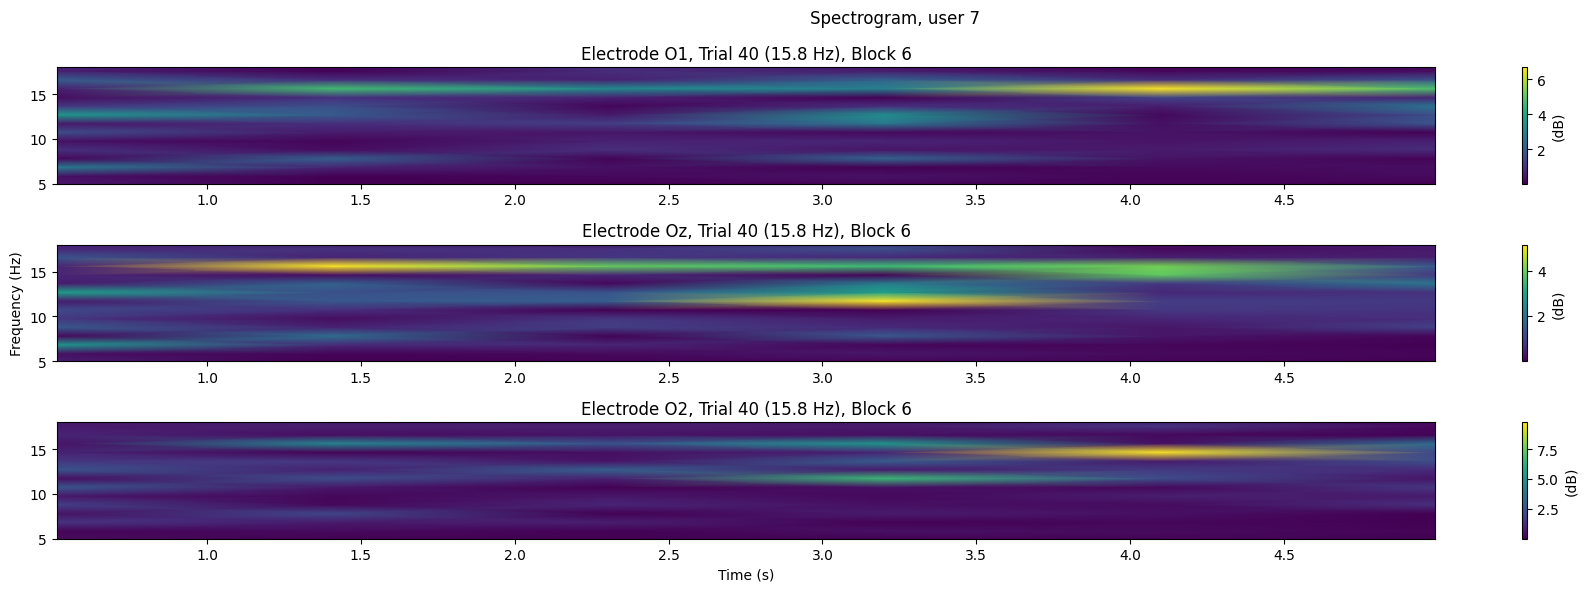

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(18, 6))

for i, e in enumerate(ELEC_INDEX):
    f, t, Sxx = spectrogram(filtered_data[e-1, :, TRIAL-1, BLOCK], fs=fs)
    plot_spectrogram(ax=axs[i], x=t, y=f, z=Sxx, title=f'Electrode {ELEC_LABEL[i]}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Spectrogram, user {USER_ID+1}')
fig.tight_layout()
plt.show()


B)

### The evoked response is clearly visible, with the stimulus frequency being readily identifiable, particularly in the 'PO5' and 'Oz' electrodes. The DFT magnitude plot provided the clearest representation of the stimulus frequency. The P6 electrode did not show a good representation of the stimulus.

---

In [ ]:
trial_info

,index,phases,freqs,trial_no
0,0,0.000000,8.0,1
1,1,1.570796,9.0,2
2,2,3.141593,10.0,3
3,3,4.712389,11.0,4
4,4,0.000000,12.0,5
5,5,1.570796,13.0,6
6,6,3.141593,14.0,7
7,7,4.712389,15.0,8
8,8,1.570796,8.2,9
9,9,3.141593,9.2,10


In [ ]:
TRIALS = [1, 20, 40]
TRIAL_FREQS = trial_info.loc[trial_info['trial_no'].isin(TRIALS)]['freqs'].values.tolist()
TRIAL_FREQS

[8.0, 11.4, 15.8]

In [ ]:
ELEC_INDEX[1]

62

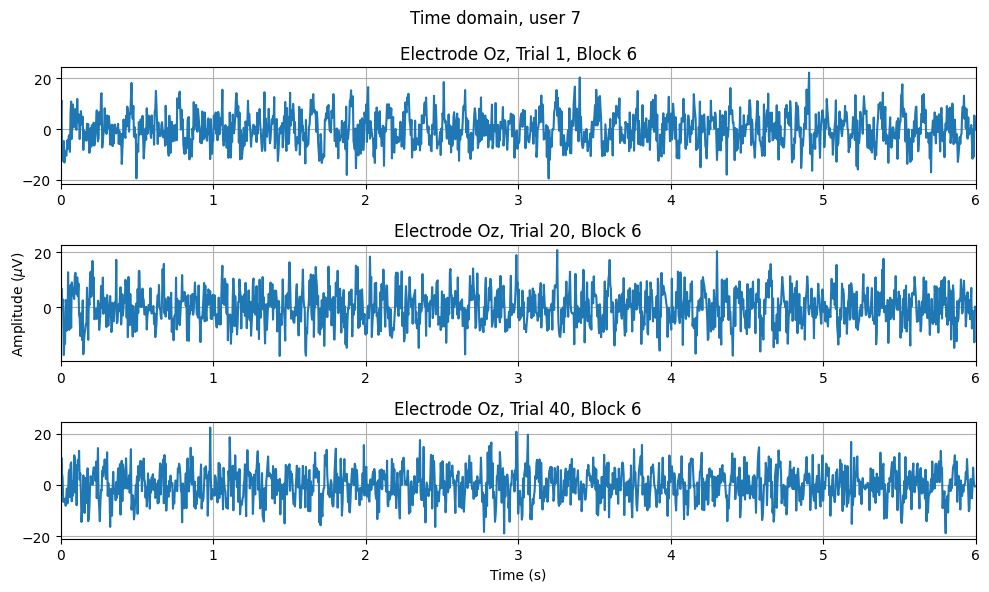

In [ ]:
t = np.arange(0, N / fs, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, tr in enumerate(TRIALS):
    plot_eeg_time(ax=axs[i], x=t, y=filtered_data[ELEC_INDEX[1]-1, :, tr-1, BLOCK], title=f'Electrode {ELEC_LABEL[1]}, Trial {tr}, Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Time domain, user {USER_ID+1}')
fig.tight_layout()
plt.show()

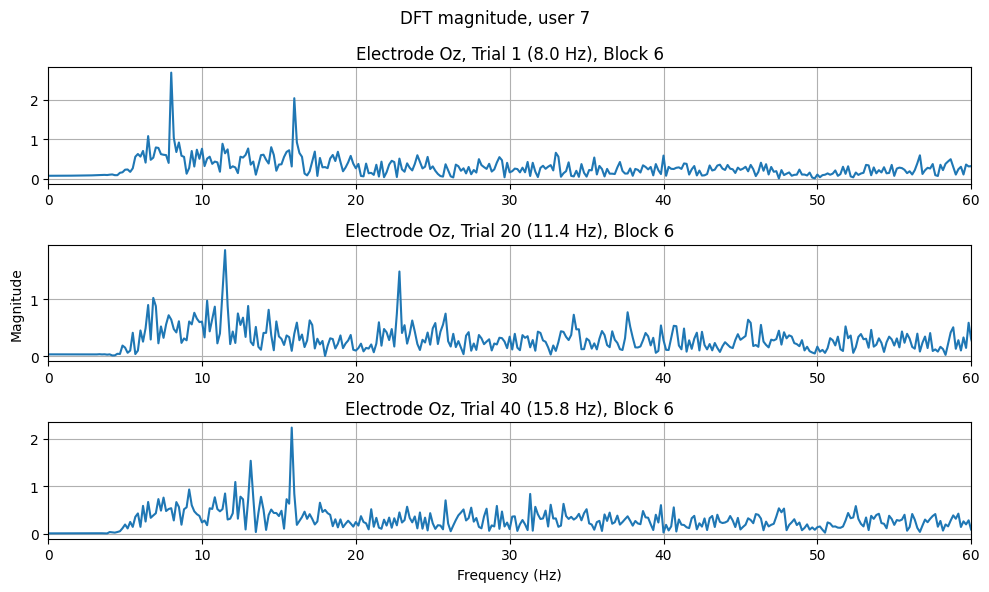

In [ ]:
freq = rfftfreq(N, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, tr in enumerate(TRIALS):
    y = rfft(filtered_data[ELEC_INDEX[1]-1, :, tr-1, BLOCK])
    plot_eeg_freq(ax=axs[i], x=freq, y=2/N*np.abs(y), title=f'Electrode {ELEC_LABEL[1]}, Trial {tr} ({TRIAL_FREQS[i]} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'DFT magnitude, user {USER_ID+1}')
fig.tight_layout()
plt.show()

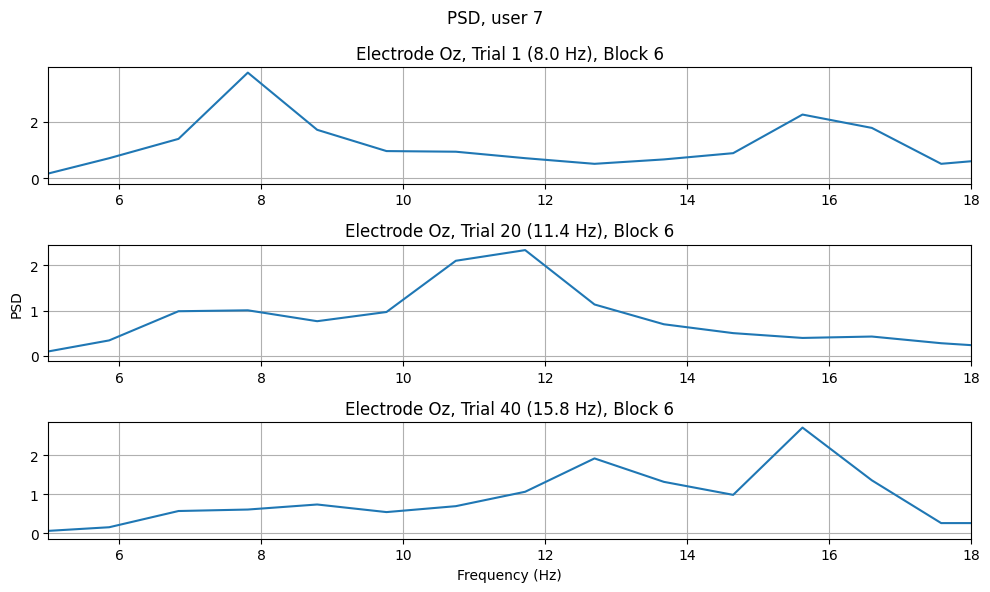

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, tr in enumerate(TRIALS):
    f, psd = welch(filtered_data[ELEC_INDEX[1]-1, :, tr-1, BLOCK], fs, scaling="density")
    plot_psd(ax=axs[i], x=f, y=psd, title=f'Electrode {ELEC_LABEL[1]}, Trial {tr} ({TRIAL_FREQS[i]} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'PSD, user {USER_ID+1}')
fig.tight_layout()
plt.show()

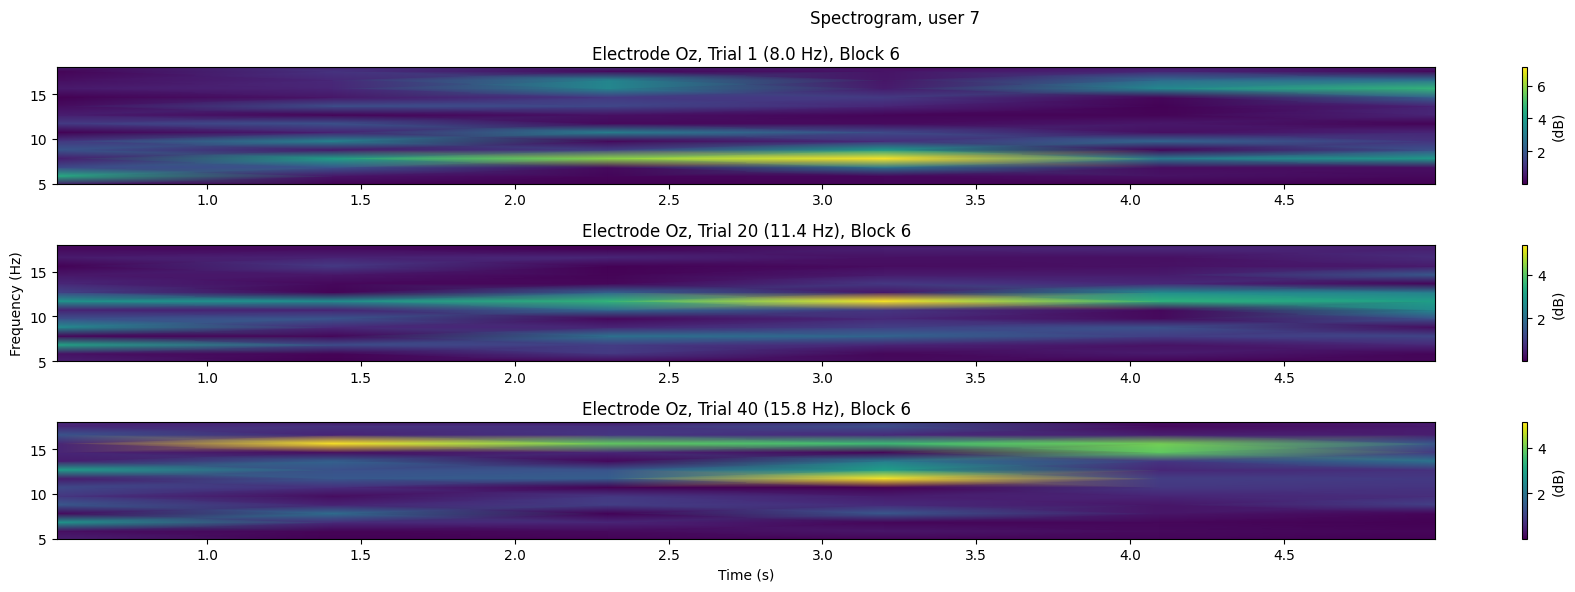

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(18, 6))

for i, tr in enumerate(TRIALS):
    f, t, Sxx = spectrogram(filtered_data[ELEC_INDEX[1]-1, :, tr-1, BLOCK], fs=fs)
    plot_spectrogram(ax=axs[i], x=t, y=f, z=Sxx, title=f'Electrode {ELEC_LABEL[1]}, Trial {tr} ({TRIAL_FREQS[i]} Hz), Block {BLOCK+1}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Spectrogram, user {USER_ID+1}')
fig.tight_layout()
plt.show()

In [ ]:
TRIAL = 40
BLOCKS = [1, 3, 6]

In [ ]:
ELEC_LABEL = "Oz"
ELEC_INDEX = electrodes[electrodes['label'].eq(ELEC_LABEL)]['index'].values.astype(int).tolist()
ELEC_INDEX

[62]

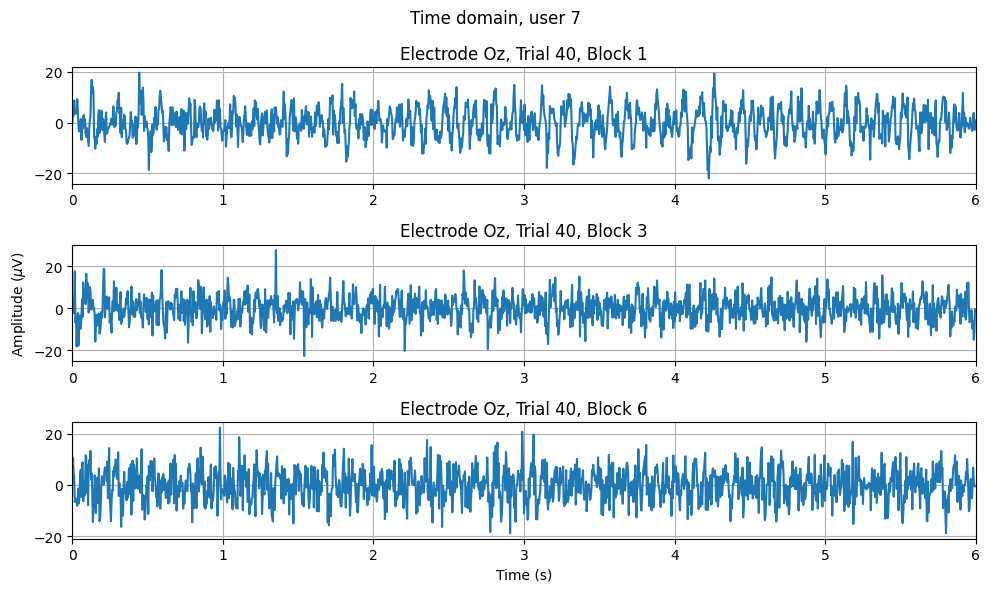

In [ ]:
t = np.arange(0, N / fs, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, bl in enumerate(BLOCKS):
    plot_eeg_time(ax=axs[i], x=t, y=filtered_data[ELEC_INDEX[0]-1, :, TRIAL-1, bl-1], title=f'Electrode {ELEC_LABEL}, Trial {TRIAL}, Block {bl}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Time domain, user {USER_ID+1}')
fig.tight_layout()
plt.show()

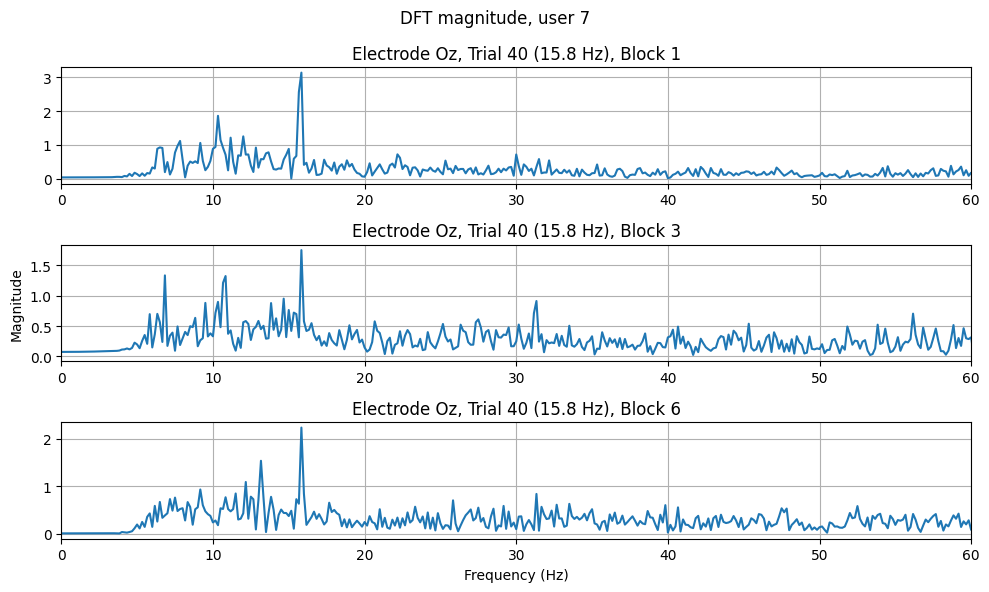

In [ ]:
freq = rfftfreq(N, 1 / fs)
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, bl in enumerate(BLOCKS):
    y = rfft(filtered_data[ELEC_INDEX[0]-1, :, TRIAL-1, bl-1])
    plot_eeg_freq(ax=axs[i], x=freq, y=2/N*np.abs(y), title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {bl}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'DFT magnitude, user {USER_ID+1}')
fig.tight_layout()
plt.show()

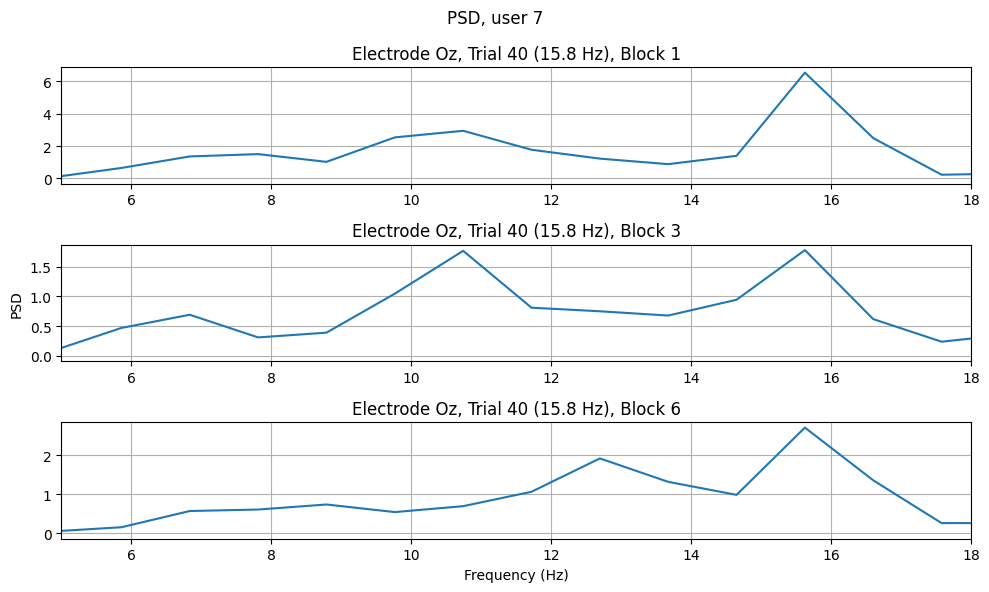

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

for i, bl in enumerate(BLOCKS):
    f, psd = welch(filtered_data[ELEC_INDEX[0]-1, :, TRIAL-1, bl-1], fs, scaling="density")
    plot_psd(ax=axs[i], x=f, y=psd, title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {bl}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'PSD, user {USER_ID+1}')
fig.tight_layout()
plt.show()

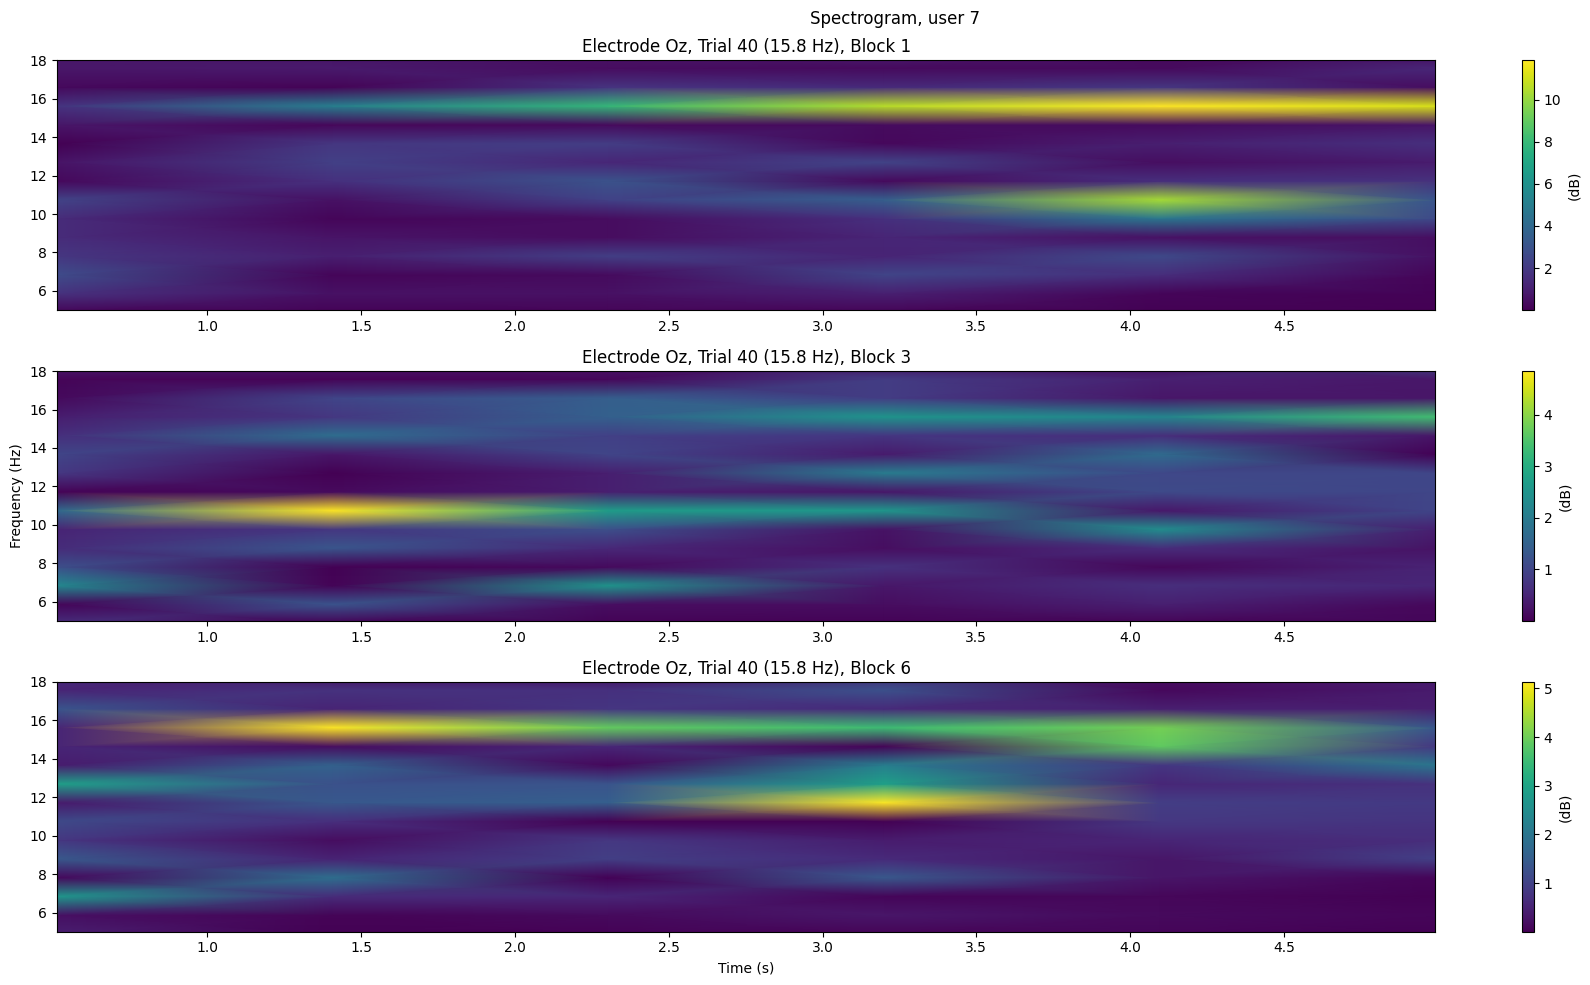

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10))

for i, bl in enumerate(BLOCKS):
    f, t, Sxx = spectrogram(filtered_data[ELEC_INDEX[0]-1, :, TRIAL-1, bl-1], fs=fs)
    plot_spectrogram(ax=axs[i], x=t, y=f, z=Sxx, title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQS[-1]} Hz), Block {bl}', add_xl=(i==2), add_yl=(i==1))

fig.suptitle(f'Spectrogram, user {USER_ID+1}')
fig.tight_layout()
plt.show()

In [ ]:
TRIAL = 40
BLOCK = 1

In [ ]:
ELEC_LABEL = "Oz"
ELEC_INDEX = electrodes[electrodes['label'].eq(ELEC_LABEL)]['index'].values.astype(int).tolist()
ELEC_INDEX

[62]

In [ ]:
USER_ID_1 = 20
data_1 = load_user_data(USER_ID_1)
volunteer_data_1 = data_1['data']

In [ ]:
fs = 250
cutoff = 3
order = 5

# Higpass filter
b, a = butter(order, cutoff, fs=(fs/2), btype="high", analog=False)

# Apply filter
filtered_data = np.zeros_like(volunteer_data)

# Apply the filter along the time axis (axis=1)
for channel in tqdm(range(volunteer_data.shape[0])):
  for trial in range(volunteer_data.shape[2]):
    for block in range(volunteer_data.shape[3]):
      signal_filtered = filtfilt(b, a, volunteer_data[channel, :, trial, block])
      filtered_data[channel, :, trial, block] = signal_filtered

100%|██████████| 64/64 [00:03<00:00, 18.32it/s]


In [ ]:
fs = 250
cutoff = 3
order = 5

# Higpass filter
b, a = butter(order, cutoff, fs=(fs/2), btype="high", analog=False)

# Apply filter
filtered_data_1 = np.zeros_like(volunteer_data_1)

# Apply the filter along the time axis (axis=1)
for channel in tqdm(range(volunteer_data_1.shape[0])):
  for trial in range(volunteer_data_1.shape[2]):
    for block in range(volunteer_data_1.shape[3]):
      signal_filtered = filtfilt(b, a, volunteer_data_1[channel, :, trial, block])
      filtered_data_1[channel, :, trial, block] = signal_filtered

100%|██████████| 64/64 [00:03<00:00, 17.22it/s]


In [ ]:
users = [USER_ID, USER_ID_1]

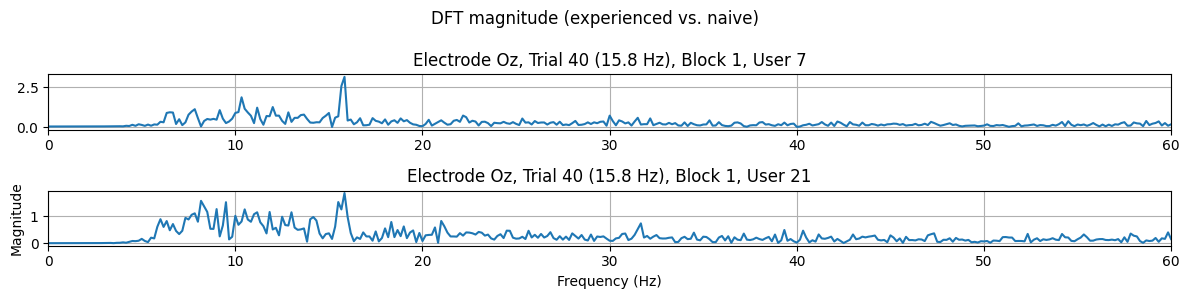

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 3))

for i, fd in enumerate([filtered_data, filtered_data_1]):
    y = rfft(fd[ELEC_INDEX[0]-1, :, TRIAL-1, BLOCK-1])
    plot_eeg_freq(ax=axs[i], x=freq, y=2/N*np.abs(y), title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK}, User {users[i]+1}', add_xl=(i==1), add_yl=(i==1))

fig.suptitle(f'DFT magnitude (experienced vs. naive)')
fig.tight_layout()
plt.show()

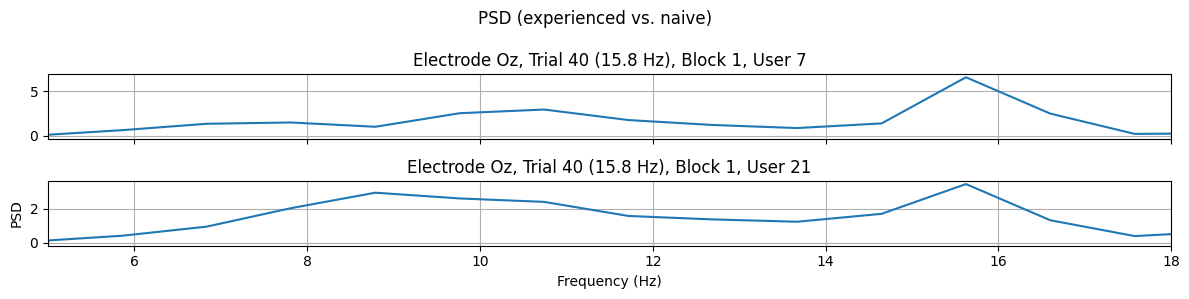

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 3), sharex=True)#, sharey=True)

for i, fd in enumerate([filtered_data, filtered_data_1]):
    f, psd = welch(fd[ELEC_INDEX[0]-1, :, TRIAL-1, BLOCK-1], fs)
    plot_psd(ax=axs[i], x=f, y=psd, title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK}, User {users[i]+1}', add_xl=(i==1), add_yl=(i==1))

fig.suptitle(f'PSD (experienced vs. naive)')
fig.tight_layout()
plt.show()

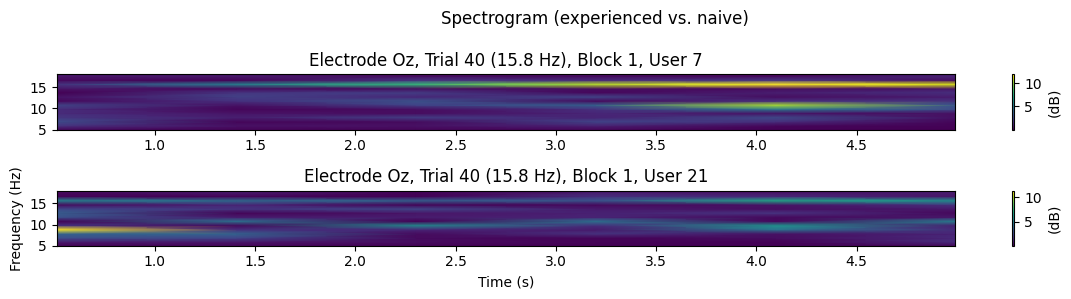

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(12, 3))

for i, fd in enumerate([filtered_data, filtered_data_1]):
    f, t, Sxx = spectrogram(fd[ELEC_INDEX[0]-1, :, TRIAL-1, BLOCK-1], fs=fs)
    plot_spectrogram(ax=axs[i], x=t, y=f, z=Sxx, title=f'Electrode {ELEC_LABEL}, Trial {TRIAL} ({TRIAL_FREQ} Hz), Block {BLOCK}, User {users[i]+1}', add_xl=(i==1), add_yl=(i==1))

fig.suptitle(f'Spectrogram (experienced vs. naive)')
fig.tight_layout()
plt.show()
